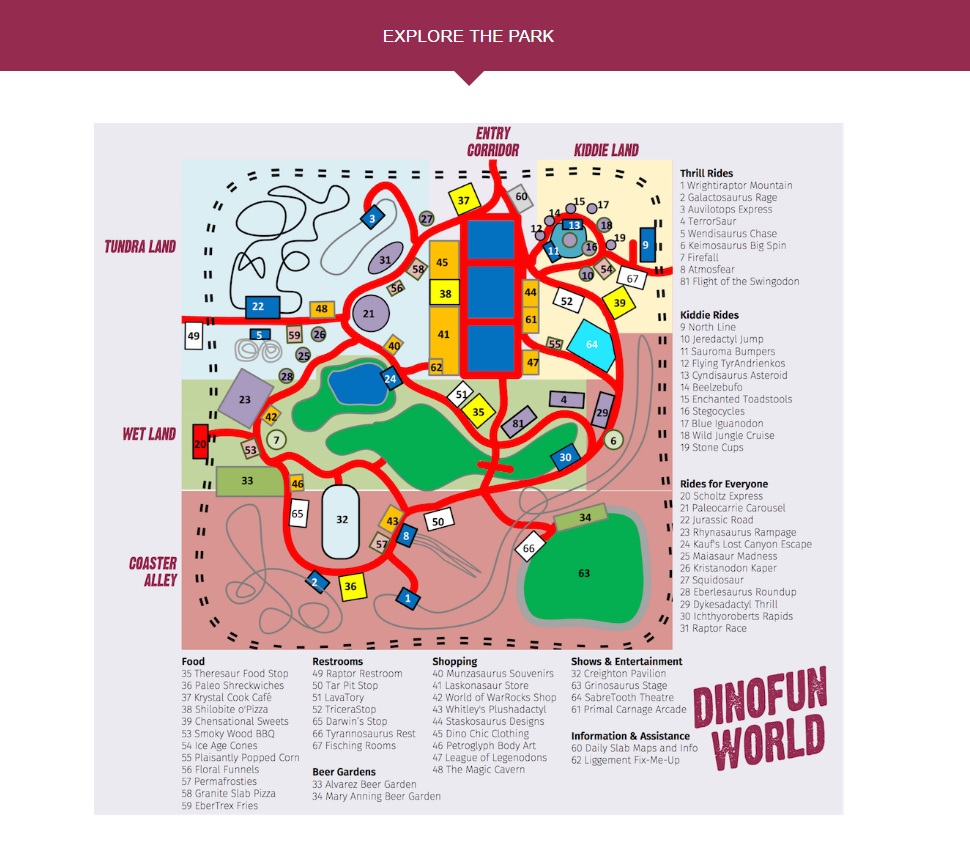

# Load libraries

In [342]:
import numpy as np
import pandas as pd
import datetime as dt
import networkx as nx

from tqdm import tqdm
tqdm.pandas()

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

# Load files

In [343]:
comm_data_files = ['comm-data-Fri.csv',
                   'comm-data-Sat.csv', 
                   'comm-data-Sun.csv']
df_comm = pd.DataFrame()
for file in comm_data_files:
    df_comm = df_comm.append(pd.read_csv(file)).reset_index(drop=True)

df_comm = df_comm[df_comm['from']!='external']
df_comm = df_comm[df_comm['to']!='external']
df_comm['from'] = df_comm['from'].astype(int)
df_comm['to'] = df_comm['to'].astype(int)
df_comm['Timestamp'] = pd.to_datetime(df_comm['Timestamp'])
df_comm.head()

,Timestamp,from,to,location
0,2014-06-06 08:03:19,439105,1053224,Kiddie Land
1,2014-06-06 08:03:19,439105,1696241,Kiddie Land
2,2014-06-06 08:03:19,439105,580064,Kiddie Land
3,2014-06-06 08:03:19,439105,1464748,Kiddie Land
4,2014-06-06 08:03:47,1836139,1593258,Entry Corridor


In [344]:
park_movement_files = ['park-movement-Fri.csv',
                       'park-movement-Sat.csv', 
                       'park-movement-Sun.csv']
df_move = pd.DataFrame()
for file in park_movement_files:
    df_move = df_move.append(pd.read_csv(file, dtype={'id': 'str','X': 'str', 'Y': 'str'}, error_bad_lines=False))
    #df_move = df_move.append(pd.read_csv(file))

# removed faulty row
df_move = df_move[df_move['id']!='id'].dropna().drop_duplicates().reset_index(drop=True)

df_move = df_move.astype({'X': 'int', 'Y': 'int'})
df_move['Timestamp'] = pd.to_datetime(df_move['Timestamp'])
df_move['id'] = df_move['id'].astype(int)
df_move.head()

,Timestamp,id,type,X,Y
0,2014-06-06 08:00:16,1591741,check-in,63,99
1,2014-06-06 08:00:16,825652,check-in,63,99
2,2014-06-06 08:00:19,179386,check-in,63,99
3,2014-06-06 08:00:19,531348,check-in,63,99
4,2014-06-06 08:00:31,1483004,check-in,0,67


In [345]:
move_parkgoers = set(df_move['id'])
comm_parkgoers = set.union(set(df_comm['from']), set(df_comm['to']))
all_parkgoers = set.union(move_parkgoers, comm_parkgoers)
both_parkgoers = set.intersection(move_parkgoers, comm_parkgoers)
move_only = set.difference(move_parkgoers, comm_parkgoers)
comm_only = set.difference(comm_parkgoers, move_parkgoers)
print('persons(comm only):', len(comm_only), comm_only)

persons(comm only): 2 {839736, 1278894}


# The crime scene is between 19<=X<=47 and 14<=Y<=40

In [346]:
X_MIN = 19
X_MAX = 47
Y_MIN = 14
Y_MAX = 40

def show_map(df_move):
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # draw park map in grayscale
    fname = 'Park Map.jpg'
    image = Image.open(fname).convert("L")
    arr = np.asarray(image)
    ax.imshow(arr, cmap='gray', extent=[0, 100, 0, 100])
    
    if 'type' in df_move.columns:
         # plot movement
        ax.scatter(df_move[df_move['type']!='check-in'][['X', 'Y']].drop_duplicates()['X'], df_move[df_move['type']!='check-in'][['X', 'Y']].drop_duplicates()['Y'])
        # plot check-in
        ax.scatter(df_move[df_move['type']=='check-in'][['X', 'Y']].drop_duplicates()['X'], df_move[df_move['type']=='check-in'][['X', 'Y']].drop_duplicates()['Y'], c='r')
        
    else:
        ax.scatter(df_move[['X', 'Y']].drop_duplicates()['X'], df_move[['X', 'Y']].drop_duplicates()['Y'])

    # draw a rectangle surrounding the crime scene
    rect = patches.Rectangle((X_MIN, Y_MIN), X_MAX-X_MIN, Y_MAX-Y_MIN, linewidth=3, edgecolor='y', facecolor='none')
    ax.add_patch(rect)
    
    plt.show()

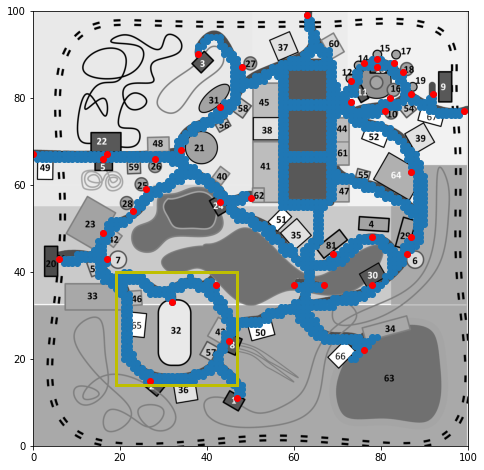

In [347]:
show_map(df_move)

# Find parkgoers who moved too fast

In [348]:
# get timestamp and coordinates of next location
df_move = df_move.sort_values(by=['id', 'Timestamp']).reset_index(drop=True)
for col in ['Timestamp', 'X', 'Y']:
    df_move.loc[df_move['id']==df_move['id'].shift(-1), 'next_'+col] = df_move[col].shift(-1)
df_move = df_move.dropna()
df_move['next_X'] = df_move['next_X'].astype(int)
df_move['next_Y'] = df_move['next_Y'].astype(int)
# exclude comparison with last timestamp of the day before
df_move = df_move[df_move['Timestamp'].dt.date==df_move['next_Timestamp'].dt.date].reset_index(drop=True)

def distinct_location(df_move):
    # if the parkgoer is still at the same location, take the previous Timestamp
    df_move.loc[(df_move['X'].shift(1)==df_move['next_X'].shift(1))&(df_move['Y'].shift(1)==df_move['next_Y'].shift(1)), 'change_Timestamp'] = df_move['Timestamp'].shift(1)
    df_move.loc[df_move['change_Timestamp'].notnull(), 'Timestamp'] = df_move['change_Timestamp']
    df_move = df_move.drop_duplicates(subset=['id', 'Timestamp', 'X', 'Y'], keep='last')
    return df_move.drop('change_Timestamp', axis=1).reset_index(drop=True)

for i in tqdm(range(10)):
    # repeat until all locations are in one distinct row
    df_move = distinct_location(df_move)
    if len(df_move[(df_move['X']==df_move['next_X'])&(df_move['Y']==df_move['next_Y'])])==0:
        break

# calculate the duration and speed of each person whenever they move
df_move['duration'] = df_move['next_Timestamp'] - df_move['Timestamp']
df_move['distance'] = (((df_move['X']-df_move['next_X'])**2)+((df_move['Y']-df_move['next_Y'])**2))**0.5
df_move['speed'] = (0.005*df_move['distance'])/(df_move['duration'].dt.total_seconds()/60/60)

df_move = df_move[df_move['duration']>=dt.timedelta(seconds=0)]
df_teleported = df_move[df_move['duration']<dt.timedelta(seconds=1)]
df_move = df_move[df_move['duration']>=dt.timedelta(seconds=1)].reset_index(drop=True).drop('type', axis=1)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:35<00:00,  9.55s/it]


In [349]:
df_teleported['id'].unique()

array([1600469, 1983765])

# Not possible to walk faster than 100km/h

In [350]:
df_move[df_move['speed']>100]

,Timestamp,id,X,Y,next_Timestamp,next_X,next_Y,duration,distance,speed
2585386,2014-06-07 12:01:16,212756,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
2885691,2014-06-07 12:01:16,237750,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
9552196,2014-06-07 12:01:16,786972,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
17352910,2014-06-07 12:01:16,1421406,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
17605297,2014-06-07 12:01:17,1440397,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:07,91.181138,234.465784
18114577,2014-06-07 12:01:16,1484697,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
24244876,2014-06-07 15:06:29,1983765,47,28,2014-06-07 15:06:30,75,22,0 days 00:00:01,28.635642,515.441558
24244878,2014-06-07 15:06:42,1983765,48,29,2014-06-07 15:06:43,74,23,0 days 00:00:01,26.683328,480.299906
24244880,2014-06-07 15:06:55,1983765,49,28,2014-06-07 15:06:56,73,24,0 days 00:00:01,24.331050,437.958902
24244882,2014-06-07 15:07:08,1983765,50,28,2014-06-07 15:07:09,72,24,0 days 00:00:01,22.360680,402.492236


In [351]:
df_max_speed = df_move[df_move['speed']>100].sort_values(by='speed', ascending=False).drop_duplicates(subset='id').rename({'speed':'max_speed'}, axis=1).reset_index(drop=True)
df_max_speed

,Timestamp,id,X,Y,next_Timestamp,next_X,next_Y,duration,distance,max_speed
0,2014-06-07 15:06:29,1983765,47,28,2014-06-07 15:06:30,75,22,0 days 00:00:01,28.635642,515.441558
1,2014-06-07 12:01:17,1440397,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:07,91.181138,234.465784
2,2014-06-07 12:01:16,212756,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
3,2014-06-07 12:01:16,237750,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
4,2014-06-07 12:01:16,1484697,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
5,2014-06-07 12:01:16,1421406,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561
6,2014-06-07 12:01:16,786972,14,44,2014-06-07 12:01:24,99,77,0 days 00:00:08,91.181138,205.157561


In [352]:
set(df_teleported['id']).intersection(set(df_max_speed['id']))

{1983765}

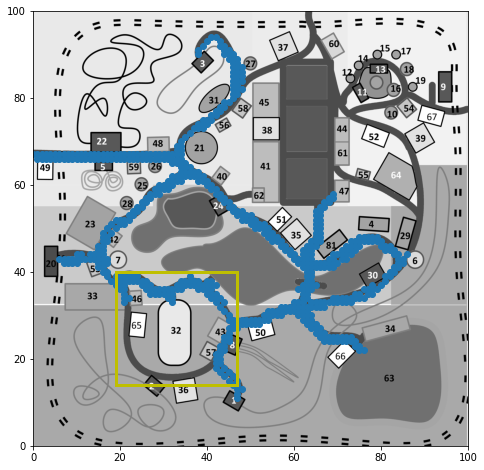

In [353]:
show_map(df_move[df_move['id']==1983765])

In [354]:
df_comm[df_comm['from']=='1983765']

,Timestamp,from,to,location


In [355]:
df_comm[df_comm['to']=='1983765']

,Timestamp,from,to,location


# 1983765 is highly suspicious
- movement glitches around
- no communications with other parkgoers

# where was 1983765 when the crime happened?

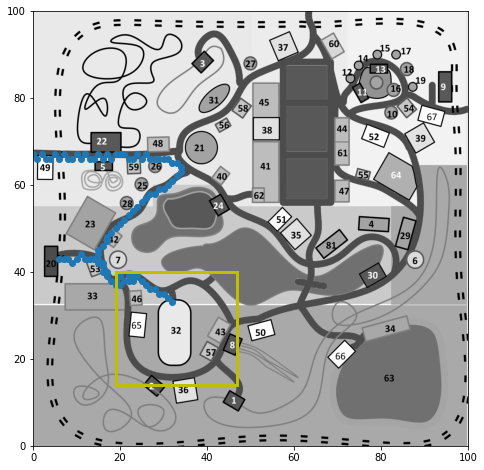

In [356]:
show_map(df_move[(df_move['Timestamp']>=dt.datetime(2014,6,8,8,0))&
                 (df_move['Timestamp']<=dt.datetime(2014,6,8,11,30))&
                 (df_move['id']==1983765)])

In [357]:
df_move[(df_move['Timestamp']>=dt.datetime(2014,6,8,8,0))&
        (df_move['Timestamp']<=dt.datetime(2014,6,8,11,30))&
        (df_move['id']==1983765)&
        (df_move['X']>=X_MIN)&(df_move['Y']>=Y_MIN)&
        (df_move['X']<=X_MAX)&(df_move['Y']<=Y_MAX)&
        (df_move['duration']>=dt.timedelta(minutes=15))].sort_values(by='duration', ascending=False)

,Timestamp,id,X,Y,next_Timestamp,next_X,next_Y,duration,distance,speed
24245469,2014-06-08 08:32:38,1983765,32,33,2014-06-08 09:08:18,31,34,0 days 00:35:40,1.414214,0.011895


# 1983765 spent 35 minutes at (32, 33) from 0832hrs to 0908hrs
- find other parkgoers who were at (32,33) with 1983765
- take 15 minutes as duration required for time overlap

In [358]:
def find_accomplice(target=1983765, X=32, Y=33, 
                    time_start=dt.datetime(2014,6,8,8,0), 
                    time_end=dt.datetime(2014,6,8,10,0), 
                    min_time = dt.timedelta(minutes=15), suffix=''):

    df_move_incident = df_move[(df_move['Timestamp']>=time_start)&(df_move['Timestamp']<=time_end)&
                               (df_move['X']==X)&(df_move['Y']==Y)][['id', 'Timestamp', 'next_Timestamp']].drop_duplicates()
                
    possible_acmpl = []
    df_target = df_move_incident[df_move_incident['id']==target].reset_index(drop=True)
    for i in range(len(df_target)):
        START_target = df_target['Timestamp'][i]
        END_target = df_target['next_Timestamp'][i]

        for acmpl in (df_move_incident[df_move_incident['id']!=target]['id'].unique()):
            df_acmpl = df_move_incident[df_move_incident['id']==acmpl].reset_index(drop=True)
            for i, START_acmpl in enumerate(df_acmpl['Timestamp']):
                END_acmpl = df_acmpl['next_Timestamp'][i]
                time_overlap = min(END_target, END_acmpl) - max(START_target, START_acmpl)
                if time_overlap > dt.timedelta(minutes=0):
                    possible_acmpl.append([acmpl, time_overlap])
    possible_acmpl = pd.DataFrame(possible_acmpl, columns=['id', 'time_overlap_'+suffix])
    return possible_acmpl[possible_acmpl['time_overlap_'+suffix]>min_time].sort_values(by='time_overlap_'+suffix, ascending=False).reset_index(drop=True)

In [359]:
accomplice_crime = find_accomplice(time_start=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15), 
                                   time_end=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15),
                                   suffix='crime')
accomplice_crime

,id,time_overlap_crime
0,423861,0 days 00:35:40
1,1877839,0 days 00:35:40
2,1643608,0 days 00:35:40
3,1379586,0 days 00:35:40
4,2090048,0 days 00:35:14
...,...,...
250,1008236,0 days 00:15:05
251,1386541,0 days 00:15:05
252,1180630,0 days 00:15:04
253,105229,0 days 00:15:04


# where else did 1983765 spend a long duration at?

In [360]:
df_long_duration = df_move[df_move['id']==1983765]
df_long_duration = df_long_duration[df_long_duration['duration']>dt.timedelta(minutes=15)].sort_values(by='duration', ascending=False).reset_index(drop=True)
df_long_duration

,Timestamp,id,X,Y,next_Timestamp,next_X,next_Y,duration,distance,speed
0,2014-06-08 09:13:56,1983765,6,43,2014-06-08 11:33:28,7,42,0 days 02:19:32,1.414214,0.003041
1,2014-06-06 16:15:46,1983765,42,37,2014-06-06 17:52:11,41,36,0 days 01:36:25,1.414214,0.004400
2,2014-06-07 12:51:42,1983765,69,44,2014-06-07 14:00:26,68,43,0 days 01:08:44,1.414214,0.006173
3,2014-06-06 15:10:39,1983765,21,33,2014-06-06 16:10:34,22,34,0 days 00:59:55,1.414214,0.007081
4,2014-06-07 18:58:38,1983765,16,49,2014-06-07 19:50:20,17,48,0 days 00:51:42,1.414214,0.008206
5,2014-06-07 16:52:49,1983765,69,58,2014-06-07 17:31:14,69,57,0 days 00:38:25,1.000000,0.007809
6,2014-06-06 14:28:57,1983765,42,37,2014-06-06 15:05:27,41,37,0 days 00:36:30,1.000000,0.008219
7,2014-06-08 08:32:38,1983765,32,33,2014-06-08 09:08:18,31,34,0 days 00:35:40,1.414214,0.011895
8,2014-06-06 18:01:30,1983765,78,48,2014-06-06 18:36:26,77,47,0 days 00:34:56,1.414214,0.012145
9,2014-06-07 16:09:59,1983765,32,33,2014-06-07 16:40:54,32,34,0 days 00:30:55,1.000000,0.009704


In [361]:
# find parkgoers with high time overlap with 1983765 +- 15 minutes
df_accomplices = df_max_speed[['id', 'max_speed']].reset_index(drop=True)
for i in range(len(df_long_duration)):
    df_accomplices = df_accomplices.merge(
        find_accomplice(X=df_long_duration['X'][i], 
                        Y=df_long_duration['Y'][i], 
                        time_start=df_long_duration['Timestamp'][i]-dt.timedelta(minutes=15), 
                        time_end=df_long_duration['next_Timestamp'][i]+dt.timedelta(minutes=15), 
                        suffix='('+str(df_long_duration['X'][i])+','+str(df_long_duration['Y'][i])+')_'+str(df_long_duration['Timestamp'][i])),
        on='id', how='outer')
time_overlap_Col = [col for col in df_accomplices.columns if 'time_overlap' in col]
df_accomplices['total_time'] = df_accomplices[time_overlap_Col].fillna(dt.timedelta(seconds=0)).sum(axis=1)
df_accomplices = df_accomplices[df_accomplices['total_time']>dt.timedelta(seconds=0)]
accomplice_crime = accomplice_crime.merge(df_accomplices, on='id', how='inner')
# drop columns which are all empty
accomplice_crime = accomplice_crime.dropna(axis=1, how='all')
accomplice_crime

,id,time_overlap_crime,"time_overlap_(6,43)_2014-06-08 09:13:56","time_overlap_(42,37)_2014-06-06 16:15:46","time_overlap_(69,44)_2014-06-07 12:51:42","time_overlap_(21,33)_2014-06-06 15:10:39","time_overlap_(32,33)_2014-06-08 08:32:38","time_overlap_(78,48)_2014-06-06 18:01:30","time_overlap_(6,43)_2014-06-07 10:49:16","time_overlap_(32,33)_2014-06-06 13:39:20","time_overlap_(76,22)_2014-06-07 14:44:24","time_overlap_(32,33)_2014-06-07 08:57:58",total_time
0,423861,0 days 00:35:40,NaT,NaT,NaT,NaT,0 days 00:35:40,NaT,NaT,NaT,NaT,NaT,0 days 00:35:40
1,1877839,0 days 00:35:40,NaT,NaT,NaT,NaT,0 days 00:35:40,NaT,NaT,NaT,NaT,NaT,0 days 00:35:40
2,1643608,0 days 00:35:40,NaT,NaT,NaT,NaT,0 days 00:35:40,NaT,NaT,NaT,NaT,NaT,0 days 00:35:40
3,1379586,0 days 00:35:40,NaT,NaT,NaT,NaT,0 days 00:35:40,NaT,NaT,NaT,NaT,NaT,0 days 00:35:40
4,2090048,0 days 00:35:14,NaT,NaT,NaT,NaT,0 days 00:35:14,NaT,NaT,NaT,NaT,NaT,0 days 00:35:14
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,1008236,0 days 00:15:05,NaT,NaT,NaT,NaT,0 days 00:15:05,NaT,NaT,NaT,NaT,NaT,0 days 00:15:05
250,1386541,0 days 00:15:05,NaT,NaT,NaT,NaT,0 days 00:15:05,NaT,0 days 00:30:45,NaT,NaT,NaT,0 days 00:45:50
251,1180630,0 days 00:15:04,NaT,NaT,NaT,NaT,0 days 00:15:04,NaT,0 days 00:30:45,NaT,NaT,NaT,0 days 00:45:49
252,105229,0 days 00:15:04,NaT,NaT,NaT,NaT,0 days 00:15:04,NaT,0 days 00:30:45,NaT,NaT,NaT,0 days 00:45:49


# assume culprits will not communicate in large groups

In [362]:
# exclude those who communicated with 10 or more people within the suspected accomplices
df_comm_aggregated = df_comm.groupby(['from', 'to']).size().sort_values(ascending=False).reset_index(name='count')
df_comm_aggregated = df_comm_aggregated[df_comm_aggregated['from'].isin(accomplice_crime['id'])]
df_comm_aggregated = df_comm_aggregated[df_comm_aggregated['to'].isin(accomplice_crime['id'])]
G = nx.from_pandas_edgelist(df_comm_aggregated, 'from', 'to', 'count', create_using=nx.DiGraph)
accomplice_crime['Comm_Group_within_suspects'] = '-'
group = 1
for c in nx.strongly_connected_components(G):
    if len(c) > 1:
        accomplice_crime.loc[accomplice_crime['id'].isin(c), 'Comm_Group_within_suspects'] = 'CommGroup_'+str(group)
        group += 1
accomplice_crime = accomplice_crime.merge(accomplice_crime['Comm_Group_within_suspects'].value_counts().reset_index().rename({'Comm_Group_within_suspects':'Comm_with_suspects'}, axis=1).rename({'index':'Comm_Group_within_suspects'}, axis=1), how='left', on='Comm_Group_within_suspects')
accomplice_crime['Comm_with_suspects'] = accomplice_crime['Comm_with_suspects']-1
accomplice_crime['Comm_with_suspects'] = accomplice_crime['Comm_with_suspects'].fillna(0)
accomplice_crime = accomplice_crime[accomplice_crime['Comm_with_suspects']<10]

# exclude those who communicated with 10 or more people outside the suspected accomplices
def get_comm(person):
    return df_comm[(df_comm['from']==person)&(~df_comm['to'].isin(accomplice_crime['id']))]['to'].nunique()
accomplice_crime['Comm_to_non_suspects'] = accomplice_crime['id'].apply(lambda x: get_comm(x))
accomplice_crime['Comm_to_non_suspects'] = accomplice_crime['Comm_to_non_suspects'].fillna(0)
accomplice_crime = accomplice_crime[accomplice_crime['Comm_to_non_suspects']<10]

accomplice_crime = accomplice_crime.sort_values(by='time_overlap_crime', ascending=False).reset_index(drop=True)
# drop columns which are all empty
accomplice_crime = accomplice_crime.dropna(axis=1, how='all')
for col in accomplice_crime.columns:
    if (accomplice_crime[col].equals(accomplice_crime['time_overlap_crime']))&(col!='time_overlap_crime'):
        accomplice_crime = accomplice_crime.drop(col, axis=1)
accomplice_crime.columns = accomplice_crime.columns.str.replace('32,33', 'recee')
accomplice_crime

,id,time_overlap_crime,"time_overlap_(6,43)_2014-06-08 09:13:56","time_overlap_(42,37)_2014-06-06 16:15:46","time_overlap_(21,33)_2014-06-06 15:10:39",total_time,Comm_Group_within_suspects,Comm_with_suspects,Comm_to_non_suspects
0,423861,0 days 00:35:40,NaT,NaT,NaT,0 days 00:35:40,CommGroup_3,1,1
1,1379586,0 days 00:35:40,NaT,NaT,NaT,0 days 00:35:40,CommGroup_3,1,2
2,1783900,0 days 00:29:11,NaT,NaT,NaT,0 days 00:29:11,CommGroup_25,1,1
3,150070,0 days 00:29:10,NaT,NaT,NaT,0 days 00:29:10,CommGroup_25,1,1
4,1629394,0 days 00:28:40,NaT,0 days 00:19:09,NaT,0 days 00:47:49,CommGroup_5,2,5
...,...,...,...,...,...,...,...,...,...
60,449035,0 days 00:15:52,NaT,NaT,NaT,0 days 00:15:52,CommGroup_18,1,4
61,2093917,0 days 00:15:31,NaT,NaT,NaT,0 days 00:15:31,CommGroup_23,1,1
62,533093,0 days 00:15:31,NaT,NaT,NaT,0 days 00:15:31,CommGroup_23,1,2
63,365242,0 days 00:15:21,NaT,NaT,NaT,0 days 00:15:21,CommGroup_17,1,5


# assume culprit will not attend Scott Jones shows at (76,22), 9:30 – 11:30 and 14:30 – 16:30
- arrive not more than 30min before show starts
- arrive less than 30min before show ends
- spends at least 1 hours there

In [363]:
show_goers = pd.concat([df_move[(df_move['Timestamp']>=dt.datetime(2014,6,6,9,0))&(df_move['Timestamp']<=dt.datetime(2014,6,6,10,30))],
                        df_move[(df_move['Timestamp']>=dt.datetime(2014,6,7,9,0))&(df_move['Timestamp']<=dt.datetime(2014,6,7,10,30))],
                        df_move[(df_move['Timestamp']>=dt.datetime(2014,6,6,14,0))&(df_move['Timestamp']<=dt.datetime(2014,6,6,15,30))],
                        df_move[(df_move['Timestamp']>=dt.datetime(2014,6,7,14,0))&(df_move['Timestamp']<=dt.datetime(2014,6,7,15,30))]
                       ])
show_goers = show_goers[(show_goers['X']==76)&(show_goers['Y']==22)&(show_goers['duration']>=dt.timedelta(hours=1))]

In [364]:
1983765 in show_goers['id'].unique()

False

In [365]:
accomplice_crime = accomplice_crime[~accomplice_crime['id'].isin(show_goers['id'].unique())].reset_index(drop=True)
accomplice_crime

,id,time_overlap_crime,"time_overlap_(6,43)_2014-06-08 09:13:56","time_overlap_(42,37)_2014-06-06 16:15:46","time_overlap_(21,33)_2014-06-06 15:10:39",total_time,Comm_Group_within_suspects,Comm_with_suspects,Comm_to_non_suspects
0,423861,0 days 00:35:40,NaT,NaT,NaT,0 days 00:35:40,CommGroup_3,1,1
1,1379586,0 days 00:35:40,NaT,NaT,NaT,0 days 00:35:40,CommGroup_3,1,2
2,1783900,0 days 00:29:11,NaT,NaT,NaT,0 days 00:29:11,CommGroup_25,1,1
3,150070,0 days 00:29:10,NaT,NaT,NaT,0 days 00:29:10,CommGroup_25,1,1
4,1629394,0 days 00:28:40,NaT,0 days 00:19:09,NaT,0 days 00:47:49,CommGroup_5,2,5
...,...,...,...,...,...,...,...,...,...
60,449035,0 days 00:15:52,NaT,NaT,NaT,0 days 00:15:52,CommGroup_18,1,4
61,2093917,0 days 00:15:31,NaT,NaT,NaT,0 days 00:15:31,CommGroup_23,1,1
62,533093,0 days 00:15:31,NaT,NaT,NaT,0 days 00:15:31,CommGroup_23,1,2
63,365242,0 days 00:15:21,NaT,NaT,NaT,0 days 00:15:21,CommGroup_17,1,5


# comparing their route taken with that of 1983765, take only those with at least 50% matched

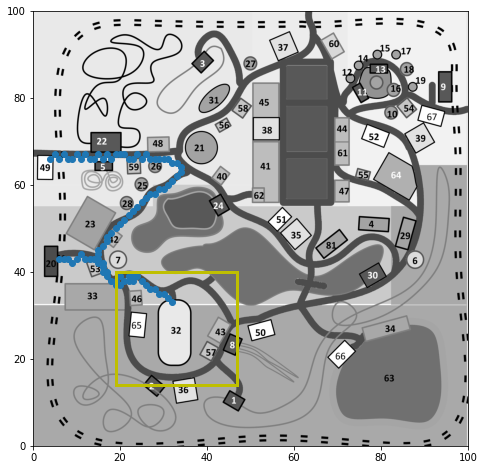

In [366]:
show_map(df_move[(df_move['Timestamp']>=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15))&
                 (df_move['Timestamp']<=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15))&
                 (df_move['id']==1983765)])

In [367]:
def route_similarity(suspect, 
                     time_start=dt.datetime(2014,6,8,8,32)-dt.timedelta(minutes=15), 
                     time_end=dt.datetime(2014,6,8,9,8)+dt.timedelta(minutes=15)):
    route_target = set(df_move[(df_move['Timestamp']>=time_start)&
                     (df_move['Timestamp']<=time_end)&
                     (df_move['id']==1983765)][['X', 'Y']].drop_duplicates().apply(tuple, axis=1))
    route_suspect = set(df_move[(df_move['Timestamp']>=time_start)&
                     (df_move['Timestamp']<=time_end)&
                     (df_move['id']==suspect)][['X', 'Y']].drop_duplicates().apply(tuple, axis=1))
    return np.round(len(route_target.intersection(route_suspect))/len(route_target),3)

In [368]:
accomplice_crime['route_similarity'] = accomplice_crime['id'].apply(lambda x: route_similarity(x))
accomplice_crime = accomplice_crime[accomplice_crime['route_similarity']>=0.5]
accomplice_crime.sort_values(by='route_similarity', ascending=False)[['id', 'time_overlap_crime', 'total_time', 'route_similarity']]

,id,time_overlap_crime,total_time,route_similarity
40,767004,0 days 00:18:29,0 days 00:18:29,0.580
39,1064643,0 days 00:18:30,0 days 00:18:30,0.568
7,2089891,0 days 00:27:03,0 days 00:27:03,0.534
8,1820567,0 days 00:27:02,0 days 00:27:02,0.500
37,595748,0 days 00:18:38,0 days 00:45:55,0.500
